In [2]:
import os
import pickle
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add
from sklearn.model_selection import train_test_split

In [3]:
vgg = VGG16()

model = Model(inputs = vgg.inputs, outputs = vgg.layers[-2].output)
print(model.summary())



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [4]:
base_direct = "archive"

features = {}
directory = os.path.join(base_direct, "Images")

for img_name in os.listdir(directory):
    img_path = directory + "/" + img_name
    image = load_img(img_path, target_size = (224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose = 0)
    image_id = img_name.split(".")[0]
    features[image_id] = feature

In [5]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [6]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [68]:
with open(os.path.join("./archive", 'captions.txt')) as f:
    next(f)
    captions_doc = f.read()

mapping = {}
for line in captions_doc.split("\n"):
    tokens = line.split(",")
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split(".")[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

all_cap = []
for key in mapping:
    for caption in mapping[key]:
        all_cap.append(caption)

max_length = max(len(caption.split()) for caption in all_cap)
max_length

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_cap)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8494

In [83]:
#train test split
image_ids = list(mapping.keys())
train, test = train_test_split(image_ids, test_size=0.05, random_state = 10)

In [84]:
from tensorflow.keras.models import load_model
new_model = load_model('./best_model.keras')

In [85]:
from PIL import Image
import matplotlib.pyplot as plt
max_length = 33
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(base_direct, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(new_model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)
    return y_pred

---------------------Actual---------------------
Skiiers on a snowy mountain .
Skiiers on top of a mountain .
Two men stand on skis and look to a snowy mountain to the right .
Two people wearing skis stand looking at a mountain .
Two skiers stand near a snowy mountain .
--------------------Predicted--------------------
startseq mountains boy watching snowboarder a in grass items into in distance man mountains a in background mountains is mountains a in background items wearing in top man them looking wearing in mountains dribbles


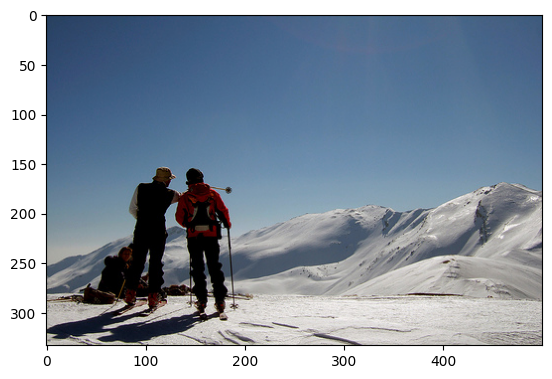

In [158]:
test1 = test[71]
caption_tested = generate_caption(test1 + ".jpg")

In [148]:
caption_words = ' '.join(caption_tested.split()[1:])
all_cap_and_test = all_cap.copy()
all_cap_and_test.append(caption_words)

all_cap_lower = [x.lower() for x in all_cap_and_test]

print(all_cap_lower[-1])

child a white jacket is white pants on front the in beach under in beach under brown herd plastic toy wearing brown ice at watching her wine the in beach watching someone 's


In [149]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfid_vec = TfidfVectorizer()
X = tfid_vec.fit_transform(all_cap_lower)

In [150]:
def pick_closest_values(arr):
    mean = np.mean(arr)
    closest_values = sorted(enumerate(arr), key=lambda x: abs(x[1] - mean))[:3]
    closest_indexes = [index for index, _ in closest_values]
    return closest_indexes

In [151]:
cap_weights = X.toarray()[-1][np.nonzero(X.toarray()[-1])]
cap_vocab = tfid_vec.get_feature_names_out()[np.nonzero(X.toarray()[-1])]

top_indexes = pick_closest_values(cap_weights)
top_words = cap_vocab[top_indexes]
print(top_words)

['someone' 'ice' 'plastic']


In [173]:
from emoji_translate.emoji_translate import Translator
import emoji


print(emoji.emojize(":blue_square:"))
emoji = Translator(exact_match_only = False, randomize = True)


for word in top_words:
    if word.endswith("es"):
        word = word[:-2]
    elif word.endswith("s"):
        word = word[:-1]
    elif word.endswith("ed"):
        word = word[:-2]
    print(emoji.emojify("mountain"))
    print(caption_tested)


🟦
⛰
startseq mountains boy watching snowboarder a in grass items into in distance man mountains a in background mountains is mountains a in background items wearing in top man them looking wearing in mountains dribbles


In [178]:
import pandas as pd
import json
df = json.load("./emoji_dataset/FindReplace.json")

AttributeError: 'str' object has no attribute 'read'